In [2]:
import csv
import numpy as np
import Loader
import tensorflow as tf
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

In [44]:

l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

def runPCANN(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal):
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtrain, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16])

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA

    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

    history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=3, batch_size=4)
    predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
    predictionsTest = np.argmax(model.predict(valData), axis=1)
    return [ predictionsTrain, predictionsTest ]



def runBasicNN(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    
    Xtrain,_,valData = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, newMean=0, newStd=1)
    
    history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=3, batch_size=4)
    predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
    predictionsVal = np.argmax(model.predict(valData), axis=1)
    return [ predictionsTrain, predictionsVal ]


def averageValues(acc, valAcc):
    accPlot = []
    valAccPlot = []
    for i in range(len(acc)):
        accuracy = 0
        valAccuracy = 0
        added = 0

        for j in range(len(acc[i])):
            if(acc[i][j] > 0.7):
                added += 1
                accuracy += acc[i][j]
                valAccuracy += valAcc[i][j]
        if(added == 0):
            added = 1
        accuracy /= added
        valAccuracy /= added
        accPlot.append(accuracy)
        valAccPlot.append(valAccuracy)
    return accPlot, valAccPlot

In [47]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)


dataDropped = [0,.1,.25,.5,.75,.9] 
accBNN = []
valAccBNN = []
accPNN = []
valAccPNN = []

for percent in dataDropped:
    currentBNNAccs = []
    currentBNNValAccs = []
    currentPNNAccs = []
    currentPNNValAccs = []
    
    for run in range(3):
     
        if(percent == 0):
            Xtrain = compoundDataTrain
            Ytrain = classTrain
        else:
            (Xtrain,_,Ytrain,_) = model_selection.train_test_split(compoundDataTrain, classTrain, test_size=percent)
        
        histBNN = runBasicNN(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal)
        currentBNNAccs.append(np.mean(histBNN[0] == Ytrain))
        currentBNNValAccs.append(np.mean(histBNN[1] == classVal))
        
        histPNN = runPCANN(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal)
        currentPNNAccs.append(np.mean(histPNN[0] == Ytrain))
        currentPNNValAccs.append(np.mean(histPNN[1] == classVal))
        
    accBNN.append(currentBNNAccs)
    valAccBNN.append(currentBNNValAccs)
    accPNN.append(currentPNNAccs)
    valAccPNN.append(currentPNNValAccs)
        #if (tempHist.history["accuracy"][-1] > .7 ): #Don't include the run if it was a constant guess
         #   currentHist.append([tempHist.history["accuracy"][-1], tempHist.history["val_accuracy"][-1]])
   

Epoch 1/3
680/680 [==============================] - 3s 4ms/step - loss: 2.8020 - accuracy: 0.8439 - val_loss: 0.9232 - val_accuracy: 0.8824
Epoch 2/3
680/680 [==============================] - 2s 3ms/step - loss: 0.7162 - accuracy: 0.9010 - val_loss: 0.6328 - val_accuracy: 0.8853
Epoch 3/3
11/11 [==============================] - 0s 2ms/step
bcut2d retention: [0.99364773]
	total: 99.36477273412314%
chi retention: [0.9541968]
	total: 95.41967968597896%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179 0.07155396 0.04590061
 0.03243    0.02673268 0.02402293]
	total: 93.80706737004658%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827]
	total: 91.43133907840061%
slogp retention: [0.44620276 0.22134465 0.15753302 0.04213752 0.03159298 0.02850562]
	total: 92.73165471968954%
estate_vsa retention: [0.29224011 0.18964809 0.14361318 0.10642656 0.07394495 0.06391846
 0.05513575]
	total: 92.49271047439824%
vsa_estate retention: [0.49255304 0.32866098 0.09719245]
	total: 91.8

11/11 [==============================] - 0s 2ms/step
bcut2d retention: [0.99369583]
	total: 99.36958340247449%
chi retention: [0.95578382]
	total: 95.57838206790495%
paoe retention: [0.31182112 0.1949913  0.13913984 0.0890255  0.07099864 0.049177
 0.0326681  0.02656695 0.02379081]
	total: 93.81792557281278%
smr retention: [0.5082773  0.24652625 0.08681082 0.07339898]
	total: 91.50133496075372%
slogp retention: [0.44750337 0.22159251 0.15672926 0.04151755 0.03132599 0.02872695]
	total: 92.73956378061763%
estate_vsa retention: [0.29515351 0.18837186 0.14165479 0.10636997 0.07285011 0.064952
 0.05488355]
	total: 92.4235786332458%
vsa_estate retention: [0.4837922  0.33357928 0.10049818]
	total: 91.7869663863608%
fr retention: [0.31750304 0.12620561 0.09803512 0.05798045 0.05549252 0.04537865
 0.0363139  0.03022982 0.02691587 0.02356387 0.01972126 0.01724005
 0.01513201 0.01197141 0.01130783 0.00998123]
	total: 90.2972636356476%
Epoch 1/3
612/612 [==============================] - 3s 3ms/st

slogp retention: [0.45129541 0.22073803 0.15369683 0.04268264 0.03194979 0.02795736]
	total: 92.83200606355884%
estate_vsa retention: [0.28961273 0.19081904 0.14579341 0.10318582 0.07576444 0.06624041
 0.0549951 ]
	total: 92.64109539934398%
vsa_estate retention: [0.47660659 0.34743064 0.09175553]
	total: 91.57927569782053%
fr retention: [0.33047933 0.12724674 0.09732488 0.05370067 0.05041596 0.04597617
 0.0354621  0.03039118 0.02732772 0.02143273 0.01936378 0.01725583
 0.01502208 0.01162603 0.01106534 0.00955429]
	total: 90.36448281959406%
Epoch 1/3
510/510 [==============================] - 2s 4ms/step - loss: 1.2639 - accuracy: 0.7752 - val_loss: 0.5754 - val_accuracy: 0.8676
Epoch 2/3
510/510 [==============================] - 2s 4ms/step - loss: 0.5009 - accuracy: 0.8778 - val_loss: 0.4760 - val_accuracy: 0.8735
Epoch 3/3
11/11 [==============================] - 0s 2ms/step
Epoch 1/3
340/340 [==============================] - 2s 4ms/step - loss: 1.2265 - accuracy: 0.5972 - val_loss

Epoch 1/3
170/170 [==============================] - 1s 5ms/step - loss: 1.8274 - accuracy: 0.6362 - val_loss: 0.7857 - val_accuracy: 0.6118
Epoch 2/3
170/170 [==============================] - 1s 4ms/step - loss: 0.7276 - accuracy: 0.6421 - val_loss: 0.7234 - val_accuracy: 0.6118
Epoch 3/3
11/11 [==============================] - 0s 2ms/step
Epoch 1/3
170/170 [==============================] - 1s 5ms/step - loss: 2.2727 - accuracy: 0.7334 - val_loss: 0.7958 - val_accuracy: 0.8676
Epoch 2/3
170/170 [==============================] - 1s 4ms/step - loss: 0.6654 - accuracy: 0.8660 - val_loss: 0.5680 - val_accuracy: 0.8882
Epoch 3/3
11/11 [==============================] - 0s 2ms/step
bcut2d retention: [0.99373454]
	total: 99.37345396728507%
chi retention: [0.95139582]
	total: 95.13958202057225%
paoe retention: [0.28577616 0.20029693 0.13324779 0.09961818 0.07906808 0.06189729
 0.03036959 0.02460604 0.02237638]
	total: 93.72564462059351%
smr retention: [0.49990703 0.24873254 0.08803689 0.0

11/11 [==============================] - 0s 2ms/step
Epoch 1/3
68/68 [==============================] - 1s 7ms/step - loss: 3.0211 - accuracy: 0.6162 - val_loss: 0.8414 - val_accuracy: 0.6118
Epoch 2/3
68/68 [==============================] - 0s 5ms/step - loss: 0.7532 - accuracy: 0.6531 - val_loss: 0.7437 - val_accuracy: 0.6118
Epoch 3/3
11/11 [==============================] - 0s 2ms/step
bcut2d retention: [0.99573128]
	total: 99.57312834420226%
chi retention: [0.95875593]
	total: 95.87559261309839%
paoe retention: [0.32804488 0.20351067 0.15400651 0.07868572 0.06095331 0.03750663
 0.02886301 0.0265211  0.02245858]
	total: 94.05504115884376%
smr retention: [0.51804129 0.23695707 0.09055732 0.07362558]
	total: 91.91812530446978%
slogp retention: [0.47246392 0.22108041 0.13278661 0.04654155 0.03437631 0.02565958]
	total: 93.290839573349%
estate_vsa retention: [0.28585243 0.1816305  0.15260864 0.11931842 0.07214543 0.06231264
 0.0533029 ]
	total: 92.71709684033776%
vsa_estate retention:

BNN Acc: [0.9105631210894369, 0.9278118609406953, 0.9428080510554737, 0.9212076583210604, 0.9248895434462445, 0.9206642066420665] 
BNN valAcc: [0.8823529411764706, 0.8955882352941176, 0.8985294117647059, 0.8897058823529411, 0.8852941176470588, 0.8470588235294119]
PNN Acc: [0.9193963930806036, 0.905521472392638, 0.8966617574864997, 0.9057437407952872, 0.0, 0.915129151291513] 
PNN valAcc: [0.888235294117647, 0.888235294117647, 0.8852941176470588, 0.8794117647058823, 0.0, 0.8401960784313726]


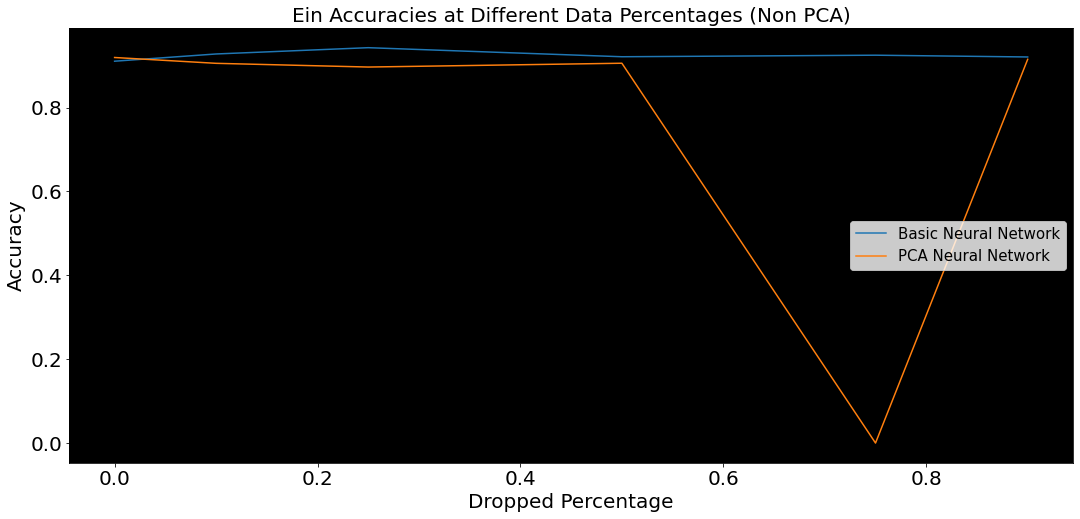

In [48]:


fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

accPlotBNN, valAccPlotBNN = averageValues(accBNN, valAccBNN)
print("BNN Acc:",accPlotBNN, "\nBNN valAcc:", valAccPlotBNN)

accPlotPNN, valAccPlotPNN = averageValues(accPNN, valAccPNN)
print("PNN Acc:",accPlotPNN, "\nPNN valAcc:", valAccPlotPNN)


ax.plot(dataDropped,accPlotBNN, label = "Basic Neural Network")
ax.plot(dataDropped,accPlotPNN, label = "PCA Neural Network")

ax.legend(loc = 'right', fontsize = 15)
ax.set_title("Ein Accuracies at Different Data Percentages (Non PCA)", fontsize = 20)
ax.set_xlabel("Dropped Percentage", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("black")